In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# Training data folder

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='E:/Flower NLP Project/df_train',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256)
)


Found 2562 files belonging to 5 classes.


# Subfolder image data

In [5]:
import os

train_dir = 'E:/Flower NLP Project/df_train'
subfolders = os.listdir(train_dir)
subfolder_counts = {}

for folder in subfolders:
    folder_path = os.path.join(train_dir, folder)
    if os.path.isdir(folder_path):
        num_images = len(os.listdir(folder_path))
        print(f"Number of images in {folder}: {num_images}")
        subfolder_counts[folder] = num_images



Number of images in daisy: 501
Number of images in dandelion: 646
Number of images in rose: 468
Number of images in sunflower: 340
Number of images in tulip: 607


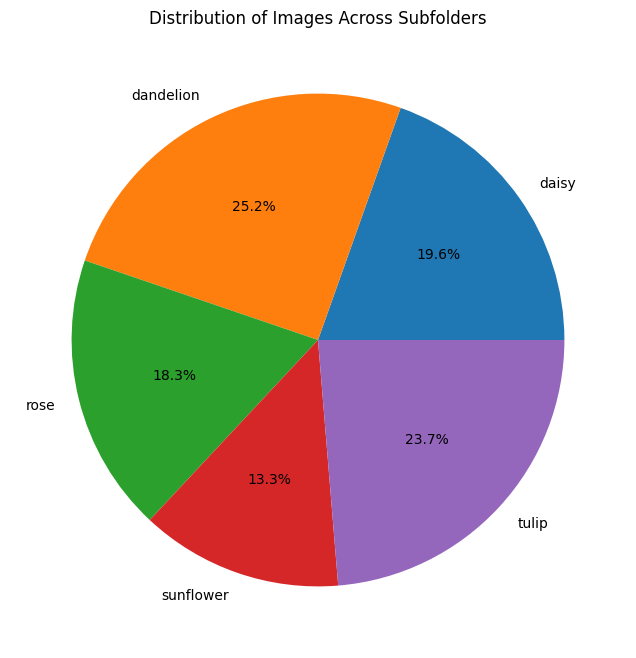

In [6]:
# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(subfolder_counts.values(), labels=subfolder_counts.keys(), autopct='%1.1f%%')
plt.title('Distribution of Images Across Subfolders')
plt.show()

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import cv2
import os
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from keras.models import Model
from tensorflow.keras.layers import Activation, GlobalAveragePooling2D, Dropout, Flatten, Dense, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization
from tensorflow.keras.layers import Add
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import Input
from keras.utils import to_categorical


In [2]:
train_path = 'E:/Flower NLP Project/df_train'
test_path = 'E:/Flower NLP Project/test'
class_names = os.listdir(train_path)
class_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [4]:
X = []
y = []

for i, class_name in enumerate(class_names): 
    class_path = os.path.join(train_path, class_name)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        image = imread(image_path) 

        image = cv2.resize(image, (224, 224))
        X.append(image)
        y.append(i)
X = np.array(X)
y = np.array(y)

In [5]:
test = []

image_names = os.listdir(test_path)
image_names.sort(key = lambda x: int(re.search(r'Image_(\d+)', x).group(1))) 

for image_name in image_names:
    
    image_path = os.path.join(test_path, image_name) 
    image = imread(image_path)
    image = cv2.resize(image, (224, 224))
    test.append(image)

print("total test size :", len(os.listdir(test_path)))    

total test size : 924


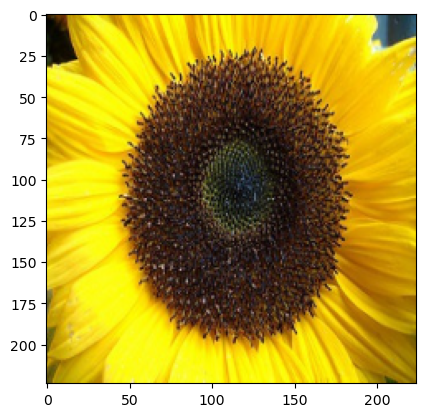

In [6]:
plt.imshow(test[1])

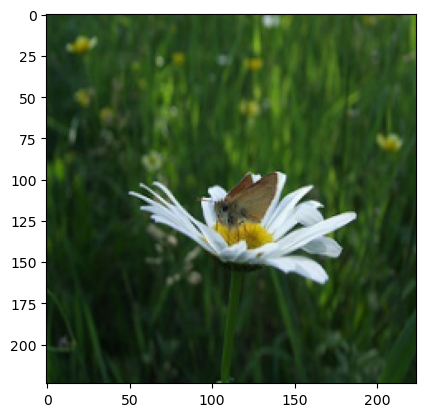

In [7]:
plt.imshow(test[923])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [9]:
# Convert target labels to one-hot encoded format
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

In [10]:
input_shape = 224, 224, 3
n_classes = 5

In [11]:
def resnet50(input_shape, n_classes):
    def identity_block(input_tensor, filters):
        """Identity block"""
        filters1, filters2, filters3 = filters

        x = Conv2D(filters1, (1, 1))(input_tensor)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(filters2, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(filters3, (1, 1))(x)
        x = BatchNormalization()(x)

        x = Add()([x, input_tensor])
        x = Activation('relu')(x)

        return x

    def convolutional_block(input_tensor, filters, strides=(2, 2)):
        """Convolutional block"""
        filters1, filters2, filters3 = filters

        x = Conv2D(filters1, (1, 1), strides=strides)(input_tensor)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(filters2, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(filters3, (1, 1))(x)
        x = BatchNormalization()(x)

        shortcut = Conv2D(filters3, (1, 1), strides=strides)(input_tensor)
        shortcut = BatchNormalization()(shortcut)

        x = Add()([x, shortcut])
        x = Activation('relu')(x)

        return x

    input = Input(input_shape)

    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPool2D((3, 3), strides=(2, 2), padding='same')(x)

    x = convolutional_block(x, [64, 64, 256], strides=(1, 1))
    x = identity_block(x, [64, 64, 256])
    x = identity_block(x, [64, 64, 256])

    x = convolutional_block(x, [128, 128, 512])
    x = identity_block(x, [128, 128, 512])
    x = identity_block(x, [128, 128, 512])
    x = identity_block(x, [128, 128, 512])

    x = convolutional_block(x, [256, 256, 1024])
    x = identity_block(x, [256, 256, 1024])
    x = identity_block(x, [256, 256, 1024])
    x = identity_block(x, [256, 256, 1024])
    x = identity_block(x, [256, 256, 1024])
    x = identity_block(x, [256, 256, 1024])

    x = convolutional_block(x, [512, 512, 2048])
    x = identity_block(x, [512, 512, 2048])
    x = identity_block(x, [512, 512, 2048])

    x = AvgPool2D((7, 7))(x)
    x = Flatten()(x)
    
    output = Dense(n_classes, activation='softmax')(x)

    model = Model(input, output)

    return model

model = resnet50(input_shape, n_classes)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 112, 112, 64)      │           9,472 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 112, 112, 64)      │             256 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 112, 112, 64)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 56, 56, 64)        │               0 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 56, 56, 64)        │           4,160 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 56, 56, 64)        │             256 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 56, 56, 64)        │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 56, 56, 64)        │          36,928 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 56, 56, 64)        │             256 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 56, 56, 64)        │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 56, 56, 256)       │          16,640 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 56, 56, 256)       │          16,640 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 56, 56, 256)       │           1,024 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_4         │ (None, 56, 56, 256)       │           1,024 │ conv2d_4[0][0]             │
│ (BatchNormalization)          │                           │               

 Total params: 23,597,957 (90.02 MB)

 Trainable params: 23,544,837 (89.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 15)
history = model.fit(X_train, y_train_encoded, epochs=100, validation_data=(X_test, y_test_encoded))

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 741s 9s/step - accuracy: 0.4478 - loss: 2.4934 - val_accuracy: 0.2190 - val_loss: 59.9501
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 557s 8s/step - accuracy: 0.5999 - loss: 1.0327 - val_accuracy: 0.2531 - val_loss: 19.5539
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 555s 8s/step - accuracy: 0.6428 - loss: 0.9228 - val_accuracy: 0.4291 - val_loss: 1.6423
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 562s 8s/step - accuracy: 0.6893 - loss: 0.7974 - val_accuracy: 0.4668 - val_loss: 1.4295
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 560s 8s/step - accuracy: 0.7224 - loss: 0.7634 - val_accuracy: 0.5566 - val_loss: 1.6504
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 557s 8s/step - accuracy: 0.7375 - loss: 0.7342 - val_accuracy: 0.3303 - val_loss: 2.0962
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 557s 8s/step - accuracy: 0.6730 - loss: 0.9378 - val_accuracy: 0.2226 - val_loss: 381.2040
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 541s 8s/step - accuracy: 0.7391 - loss: 0.7170 - val_accuracy

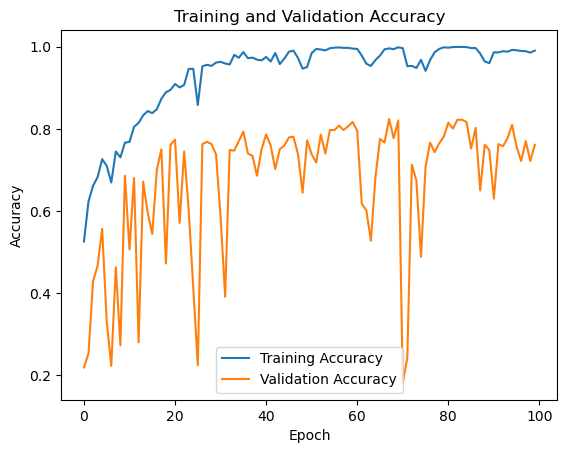

In [14]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

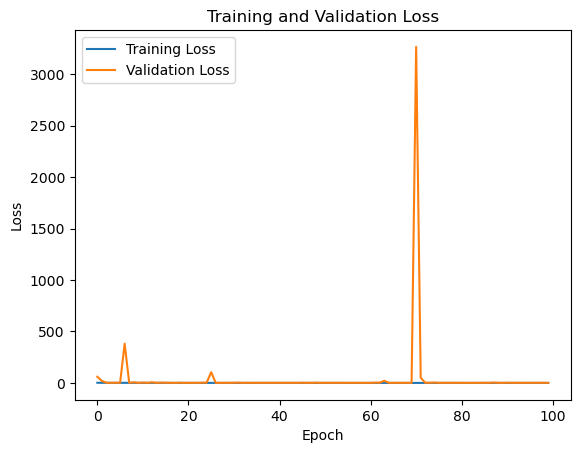

In [15]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()